/Users/rachitkumarsingh/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/rachitkumarsingh/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


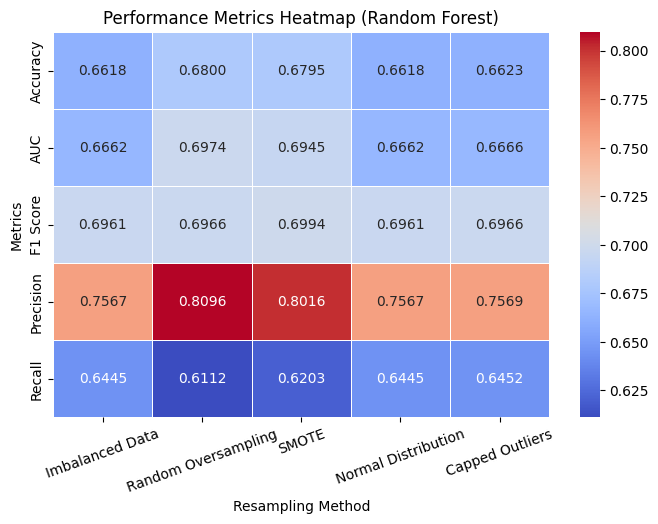

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from scipy import stats

df = pd.read_csv('../Data/Encoded_data.csv')
X = df.drop('Reached', axis=1)
y = df['Reached']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a dictionary to store the results
results = {}

# Define a list of resampling methods
resampling_methods = ["Imbalanced Data", "Random Oversampling", "SMOTE","Normal Distribution",  "Capped Outliers"]

# Loop through each resampling method
for method in resampling_methods:
    if method == "Imbalanced Data":
        X_resampled = X_train
        y_resampled = y_train
    elif method == "Random Oversampling":
        ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    elif method == "SMOTE":
        smote = SMOTE(sampling_strategy="auto", random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    elif method == "Capped Outliers":
        X_resampled = X_train.copy()
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)  # Convert to DataFrame
        for col in X_resampled.columns:
            std_dev = X_resampled[col].std()
            X_resampled[col] = np.where(X_resampled[col] > 3 * std_dev, 3 * std_dev, X_resampled[col])
        y_resampled = y_train
    elif method == "Normal Distribution":
        X_resampled = X_train.copy()
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)  # Convert to DataFrame
        for col in X_resampled.columns:
            # Check if data is positive
            if (X_resampled[col] > 0).all():
                # Apply Box-Cox transformation with a small constant
                X_resampled[col] = stats.boxcox(X_resampled[col] + 0.0001)[0]
            else:
                # Handle non-positive data (you can choose an appropriate action)
                pass
        y_resampled = y_train

    # Train Random Forest without hyperparameter tuning
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_resampled, y_resampled)

    # Make predictions on the test set
    y_pred = rf.predict(X_test)

    # Calculate evaluation metrics for Random Forest
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Store the results for Random Forest
    results[method] = {
        "Accuracy": accuracy,
        "AUC": auc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    }

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Plot a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(results_df, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title("Performance Metrics Heatmap (Random Forest)")
plt.xlabel("Resampling Method")
plt.ylabel("Metrics")
plt.xticks(rotation=20)
plt.show()


In [21]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import pickle

class AdvancedHyperparameterTunedRandomForest:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.best_model = None

    def tune_hyperparameters(self, param_dist):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        random_search = RandomizedSearchCV(
            RandomForestClassifier(),
            param_distributions=param_dist,
            n_iter=100,
            scoring='roc_auc',
            cv=cv,
            random_state=42,
            n_jobs=-1
        )
        random_search.fit(self.X_train, self.y_train)
        self.best_model = random_search.best_estimator_

    def train_best_model(self):
        if self.best_model is None:
            print("You need to tune hyperparameters first.")
        else:
            self.best_model.fit(self.X_train, self.y_train)

    def evaluate_model(self):
        if self.best_model is None:
            print("You need to train the best model first.")
        else:
            y_pred = self.best_model.predict(self.X_test)
            accuracy = accuracy_score(self.y_test, y_pred)
            auc_roc = roc_auc_score(self.y_test, self.best_model.predict_proba(self.X_test)[:, 1])
            return accuracy, auc_roc

    def save_model(self, filename):
        if self.best_model is not None:
            with open(filename, 'wb') as file:
                pickle.dump(self.best_model, file)
                print(f"Model saved as {filename}")
        else:
            print("You need to train the best model first.")

if __name__ == "__main__":

    df = pd.read_csv('../Data/Encoded_data.csv')
    X = df.drop('Reached', axis=1)
    y = df['Reached']

    # Define hyperparameter distributions for RandomizedSearchCV
    param_dist = {
        'n_estimators': np.arange(50, 500, 50),
        'max_depth': np.arange(1, 21),
        'min_samples_split': np.arange(2, 11),
        'min_samples_leaf': np.arange(1, 11),
        'max_features': ['auto', 'sqrt', 'log2', None],
        'bootstrap': [True, False],
    }

    # Create an instance of the AdvancedHyperparameterTunedRandomForest class
    model = AdvancedHyperparameterTunedRandomForest(X, y)

    # Tune hyperparameters using RandomizedSearchCV
    model.tune_hyperparameters(param_dist)

    # Train the best model
    model.train_best_model()

    # Evaluate the model
    accuracy, auc_roc = model.evaluate_model()
    print(f"Accuracy of the best model: {accuracy:.2f}")
    print(f"AUC-ROC of the best model: {auc_roc:.2f}")

    # Save the best model as a pickle file
    model.save_model("../Pickle_file/random_forest_model.pkl")


/Users/rachitkumarsingh/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rachitkumarsingh/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachitkumarsingh/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/rachitkumarsingh/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 637, in _v

Accuracy of the best model: 0.68
AUC-ROC of the best model: 0.75
Model saved as ../Pickle_file/random_forest_model.pkl
